# Part 1 Analysis

Answer the following questions:

- **1. Are there factors that make an earthquake more likely?**
- **2. Are there factors that make an earthquake more deadly?**

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import time
import ipywidgets as widgets
from ipywidgets import interact
from shapely.geometry import Point
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

In [2]:
# Set defaults
sns.set()

In [3]:
# Using matplotlib in dark mode: Comment this when switching to light mode
# plt.style.use("dark_background")

In [4]:
# We will use these ecdf function for analysis

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: the sorted data
    x = np.sort(data)

    # y-data for the ECDF: go from 1/n to 1 in equally spaced increments
    y = np.arange(1, n+1) / n

    return x, y


def plot_ecdf(data, title='', xlabel=''):
    """Plot an ecdf"""
    
    # The ecdf data
    x_data, y_data = ecdf(data)

    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(15,6))
    sns.scatterplot(x_data, y_data, linewidth=0)

    # Labels
    plt.xlabel(xlabel)
    plt.ylabel("Quantiles")
    plt.title(title)
    
    # The horizontal quartiles lines
    q1_hline = ax.axhline(0.25, color='red', linewidth=1, linestyle='--')
    median_hline = ax.axhline(0.5, color='blue', linewidth=1, linestyle='--')
    q3_hline = ax.axhline(0.75, color='green', linewidth=1, linestyle='--')
    
    # The vertical quartiles lines
    q1 = np.quantile(data, 0.25)
    median = np.median(data)
    q3 = np.quantile(data, 0.75)
    
    q1_vline = ax.axvline(q1, color='red', linewidth=1, linestyle='--')
    median_vline = ax.axvline(median, color='blue', linewidth=1, linestyle='--')
    q3_vline = ax.axvline(q3, color='green', linewidth=1, linestyle='--')
    
    # Keep data off plot edge
    plt.margins(0.02)

    plt.show()

## Reading the pre-cleaned data

In [5]:
world_earthquakes = pd.read_csv("../data/world_earthquakes_06_clean.csv")

### Checking the head and the tail

In [6]:
display(world_earthquakes.head())
display(world_earthquakes.tail())

,date,year,month,day,time,country,latitude,longitude,depth,magnitude,secondary_effects,deaths
0,1900-05-11 17:23:00,1900,5,11,17:23:00,Japan,38.7,141.1,5.0,7.0,NaN,0
1,1900-07-12 06:25:00,1900,7,12,06:25:00,Turkey,40.3,43.1,NaN,5.9,NaN,140
2,1900-10-29 09:11:00,1900,10,29,09:11:00,Venezuela,11.0,-66.0,0.0,7.7,NaN,0
3,1901-02-15 00:00:00,1901,2,15,00:00:00,China,26.0,100.1,0.0,6.5,NaN,0
4,1901-03-31 07:11:00,1901,3,31,07:11:00,Bulgaria,43.4,28.7,NaN,6.4,NaN,4


,date,year,month,day,time,country,latitude,longitude,depth,magnitude,secondary_effects,deaths
1335,2011-03-24 20:25:00,2011,3,24,20:25:00,Burma,NaN,NaN,NaN,6.8,NaN,150
1336,2011-04-07 14:32:00,2011,4,7,14:32:00,Japan,38.200,140.000,66.0,7.1,NaN,0
1337,2011-09-18 12:40:00,2011,9,18,12:40:00,India,27.723,88.064,19.7,6.9,landslide,111
1338,2011-09-23 10:41:00,2011,9,23,10:41:00,Turkey,38.600,43.500,7.2,7.1,NaN,601
1339,2018-08-05 19:46:00,2018,8,5,19:46:00,Indonesia,NaN,NaN,31.0,6.9,NaN,0


## Quick statistics and info

In [7]:
world_earthquakes.shape

(1340, 12)

In [8]:
world_earthquakes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               1340 non-null   object 
 1   year               1340 non-null   int64  
 2   month              1340 non-null   int64  
 3   day                1340 non-null   int64  
 4   time               1340 non-null   object 
 5   country            1340 non-null   object 
 6   latitude           1325 non-null   float64
 7   longitude          1325 non-null   float64
 8   depth              1250 non-null   float64
 9   magnitude          1339 non-null   float64
 10  secondary_effects  373 non-null    object 
 11  deaths             1340 non-null   int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 125.8+ KB


## Additional Cleanups

### Convert `date` to a `datetime` type

In [9]:
world_earthquakes["date"] = world_earthquakes["date"].astype("datetime64")
world_earthquakes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               1340 non-null   datetime64[ns]
 1   year               1340 non-null   int64         
 2   month              1340 non-null   int64         
 3   day                1340 non-null   int64         
 4   time               1340 non-null   object        
 5   country            1340 non-null   object        
 6   latitude           1325 non-null   float64       
 7   longitude          1325 non-null   float64       
 8   depth              1250 non-null   float64       
 9   magnitude          1339 non-null   float64       
 10  secondary_effects  373 non-null    object        
 11  deaths             1340 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(4), object(3)
memory usage: 125.8+ KB


### Dropping `year`, `month`, `day`, `time`

Since we have converted date to a `datetime` format, we can easily access all the datetime parts from that

In [10]:
world_earthquakes = world_earthquakes.drop("year", axis=1)
world_earthquakes = world_earthquakes.drop("month", axis=1)
world_earthquakes = world_earthquakes.drop("day", axis=1)
world_earthquakes = world_earthquakes.drop("time", axis=1)
world_earthquakes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               1340 non-null   datetime64[ns]
 1   country            1340 non-null   object        
 2   latitude           1325 non-null   float64       
 3   longitude          1325 non-null   float64       
 4   depth              1250 non-null   float64       
 5   magnitude          1339 non-null   float64       
 6   secondary_effects  373 non-null    object        
 7   deaths             1340 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 83.9+ KB


## Data Exploration

### Locations of the earthquakes

First, let's look at the general locations, i.e the countries

#### How many unique countries are in this dataset?

In [11]:
len(world_earthquakes["country"].unique())

108

In [12]:
world_earthquakes.shape

(1340, 8)

**Sidenotes/Remarks**
- There are 108 unique countries in this dataset.
- There are 1340 entries in this dataset.

#### What is the frequency of each country in the dataset?

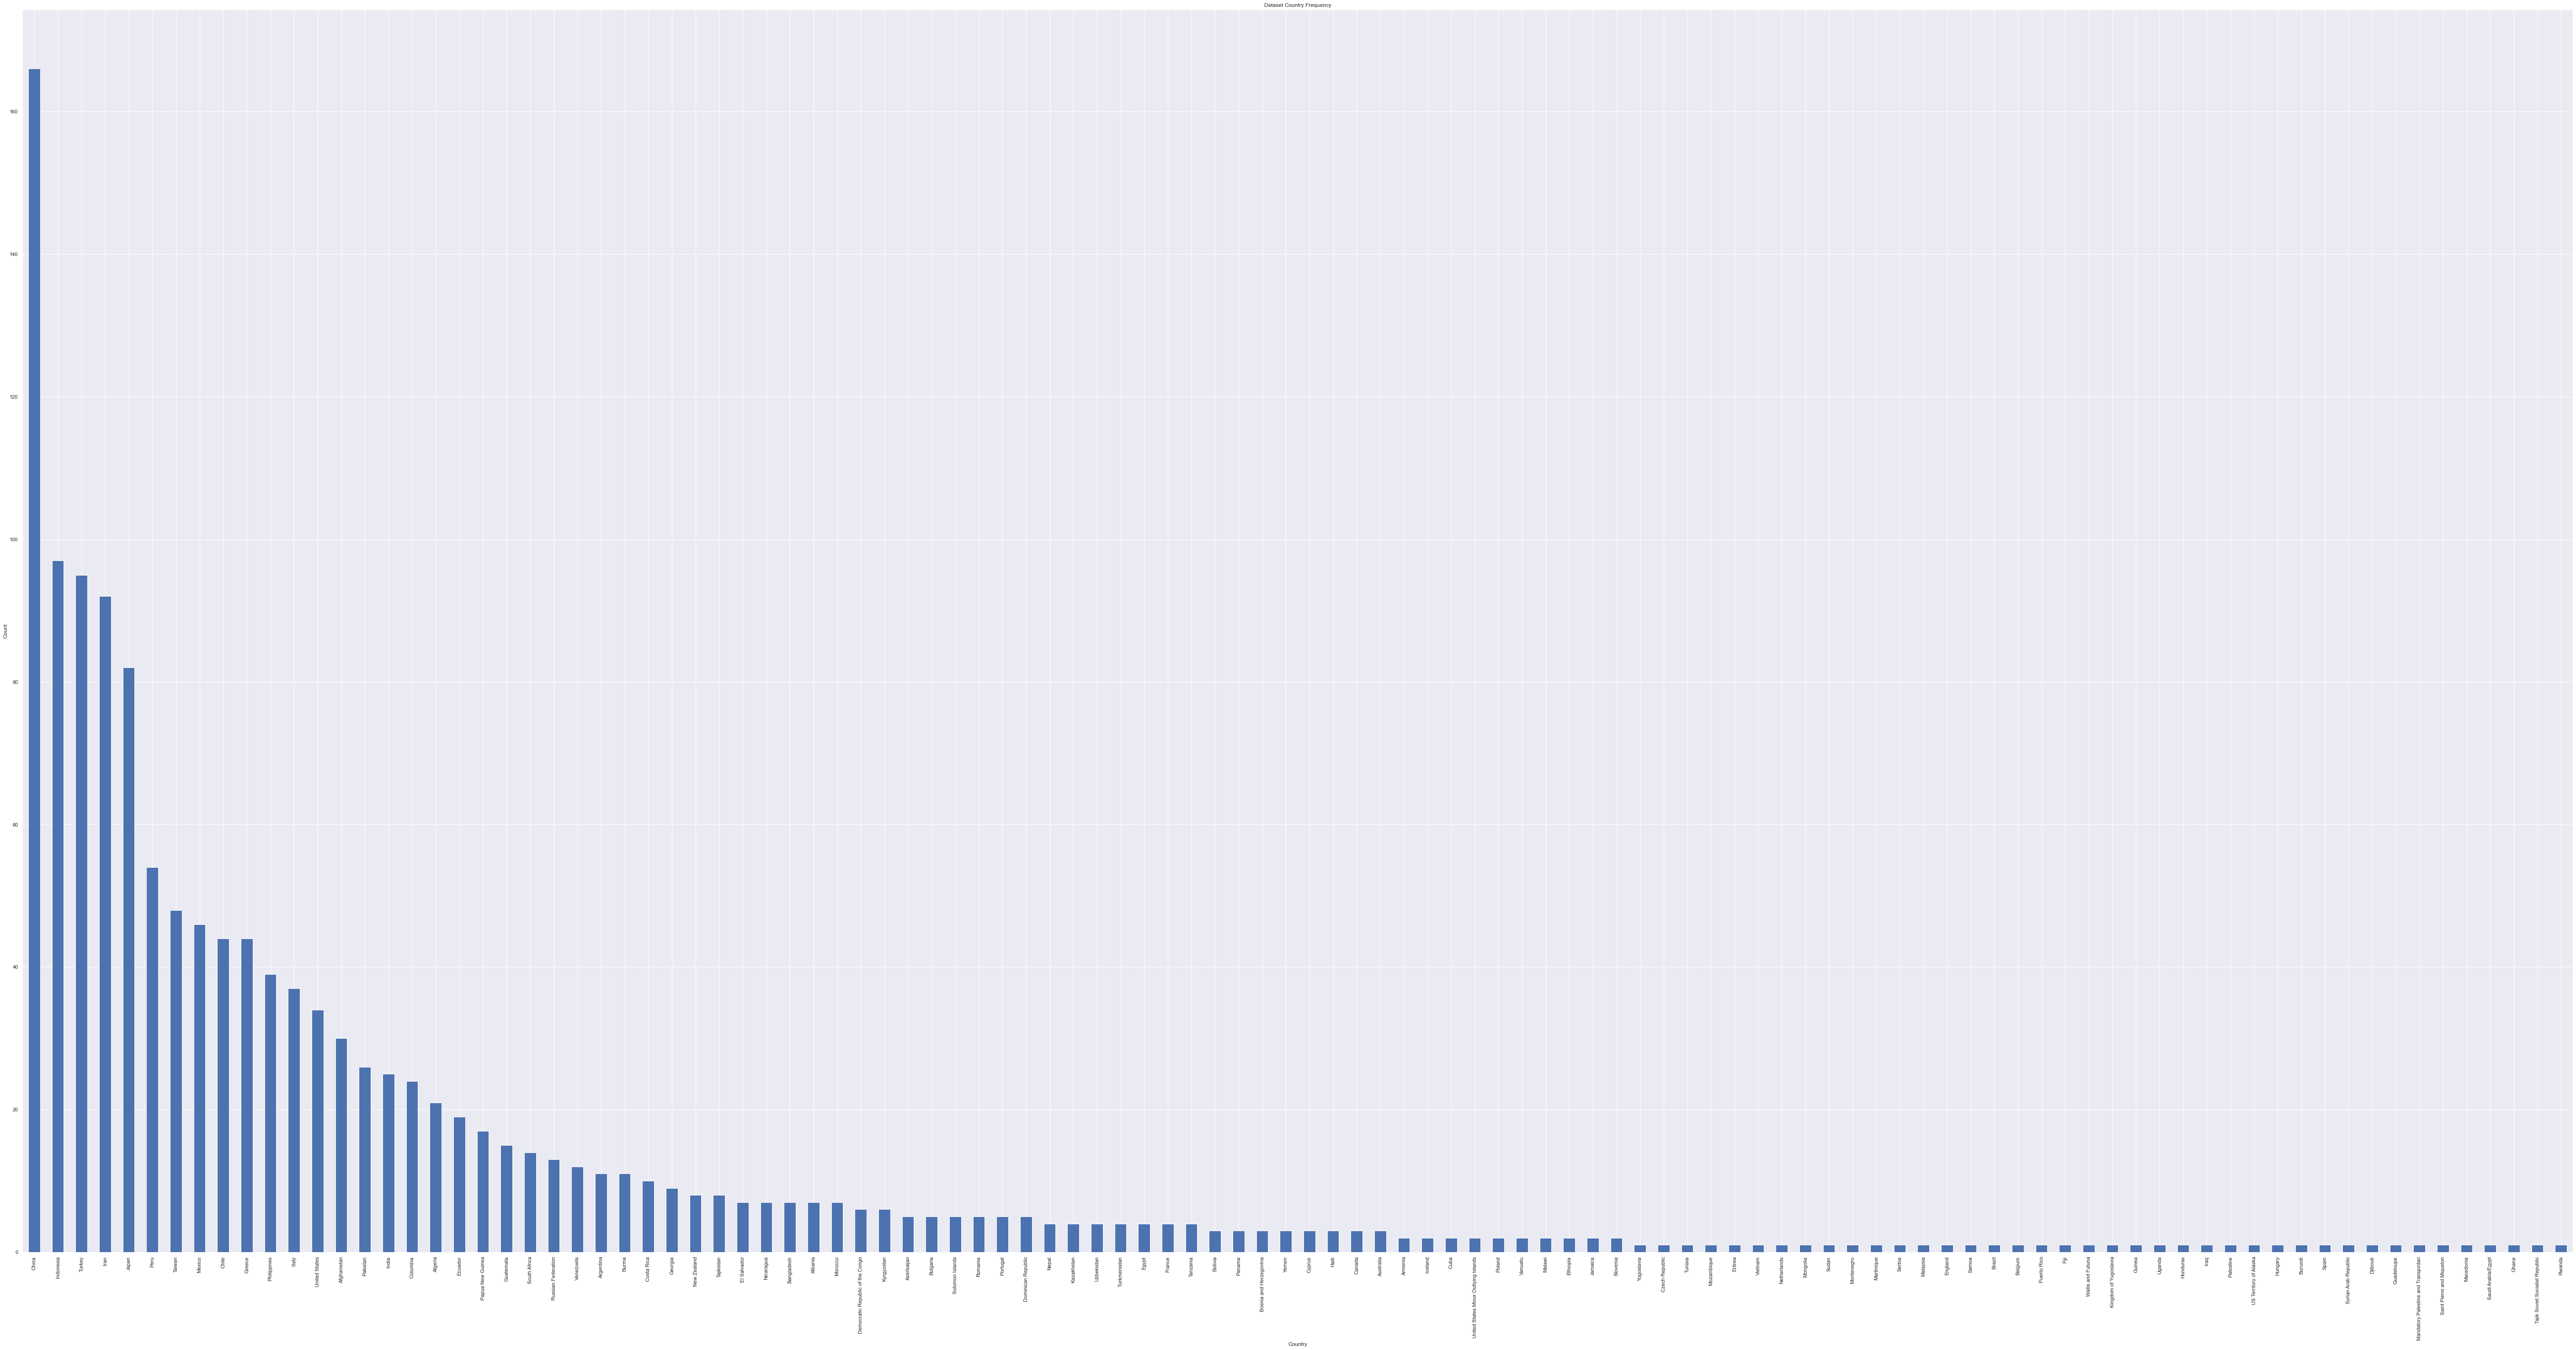

In [13]:
world_earthquakes["country"].value_counts().plot(kind="bar", figsize=(100,50))
plt.title("Dataset Country Frequency")
plt.xlabel("Country")
plt.ylabel("Count");

**Sidenotes/Remarks:**
- It looks the distribution is quite skewed: Some countries have more earthquakes than the others.

#### Who are the top 25 countries?

Let's look at the top 25 countries.

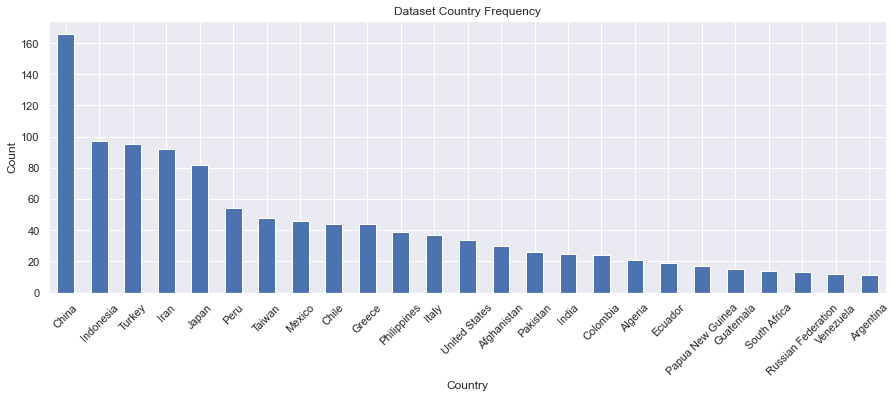

In [14]:
world_earthquakes["country"].value_counts()[:25].plot(kind="bar", rot=45, figsize=(15,5))
plt.title("Dataset Country Frequency")
plt.xlabel("Country")
plt.ylabel("Count");

In [15]:
world_earthquakes["country"].value_counts()[:25]

China                 166
Indonesia              97
Turkey                 95
Iran                   92
Japan                  82
Peru                   54
Taiwan                 48
Mexico                 46
Chile                  44
Greece                 44
Philippines            39
Italy                  37
United States          34
Afghanistan            30
Pakistan               26
India                  25
Colombia               24
Algeria                21
Ecuador                19
Papua New Guinea       17
Guatemala              15
South Africa           14
Russian Federation     13
Venezuela              12
Argentina              11
Name: country, dtype: int64

**Sidenotes/Remarks:**
- China is the top country where the most earthquakes are reported from.
- The top 5 countries are all on the Asia continent.
  - *Maybe we should look more into the distribution on the continent level?*
- Japan is ranked 5th.
- USA is ranked 13th.

#### Who are the bottom 25 countries?

Let's look at the bottom 25 countries.

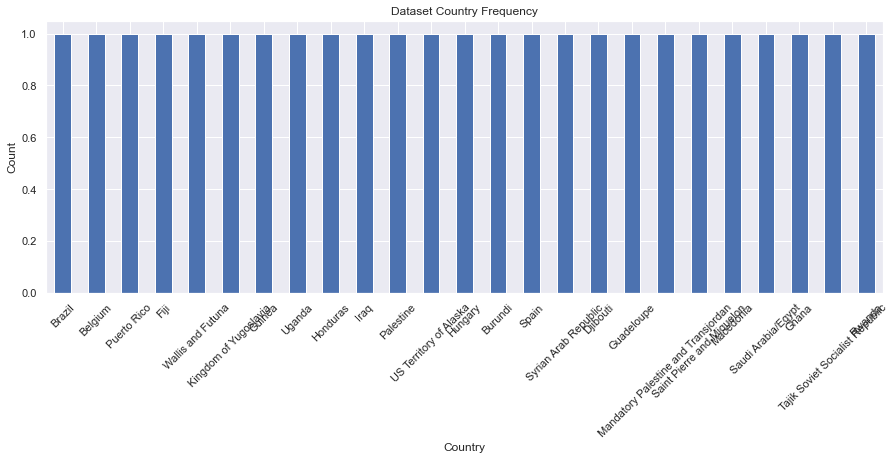

In [16]:
world_earthquakes["country"].value_counts()[-25:].plot(kind="bar", rot=45, figsize=(15,5))
plt.title("Dataset Country Frequency")
plt.xlabel("Country")
plt.ylabel("Count");

**Sidenotes/Remarks:**
- These countries only reported a single incident from this dataset.
- This could be used to confirm how infrequent earthquakes are in these countries
- We could be more specific and check all countries who only reported a single incident from this dataset
- **So the range of the country frequency is from 1 to 166 (China)**

#### How many countries only reported a single incident in this dataset?

In [17]:
single_freq_countries = world_earthquakes["country"].value_counts()[world_earthquakes["country"].value_counts().to_frame()["country"] == 1]
single_freq_countries.count()

40

#### Who are these countries?

In [18]:
single_freq_countries.sort_index()

Belgium                                1
Brazil                                 1
Burundi                                1
Czech Republic                         1
Djibouti                               1
England                                1
Eritrea                                1
Fiji                                   1
Ghana                                  1
Guadeloupe                             1
Guinea                                 1
Honduras                               1
Hungary                                1
Iraq                                   1
Kingdom of Yugoslavia                  1
Macedonia                              1
Malaysia                               1
Mandatory Palestine and Transjordan    1
Martinique                             1
Mongolia                               1
Montenegro                             1
Mozambique                             1
Netherlands                            1
Palestine                              1
Puerto Rico     

#### Who are the middle countries?

These have noticed that the top 24 countries reported between 166 (China) and 12 (Venezuela). And the bottom 40 reported only a single instance of earthquake. Let's look at the middle that doe not meet those criteria and see their distribution.

In [19]:
mid_freq_countries = world_earthquakes["country"].value_counts()[
    (world_earthquakes["country"].value_counts().to_frame()["country"] < 12) &
    (world_earthquakes["country"].value_counts().to_frame()["country"] > 1)
]
mid_freq_countries.count()

44

In [20]:
mid_freq_countries

Argentina                               11
Burma                                   11
Costa Rica                              10
Georgia                                  9
New Zealand                              8
Tajikistan                               8
El Salvador                              7
Nicaragua                                7
Bangladesh                               7
Albania                                  7
Morocco                                  7
Democratic Republic of the Congo         6
Kyrgyzstan                               6
Azerbaijan                               5
Bulgaria                                 5
Solomon Islands                          5
Romania                                  5
Portugal                                 5
Dominican Republic                       5
Nepal                                    4
Kazakhstan                               4
Uzbekistan                               4
Turkmenistan                             4
Egypt      

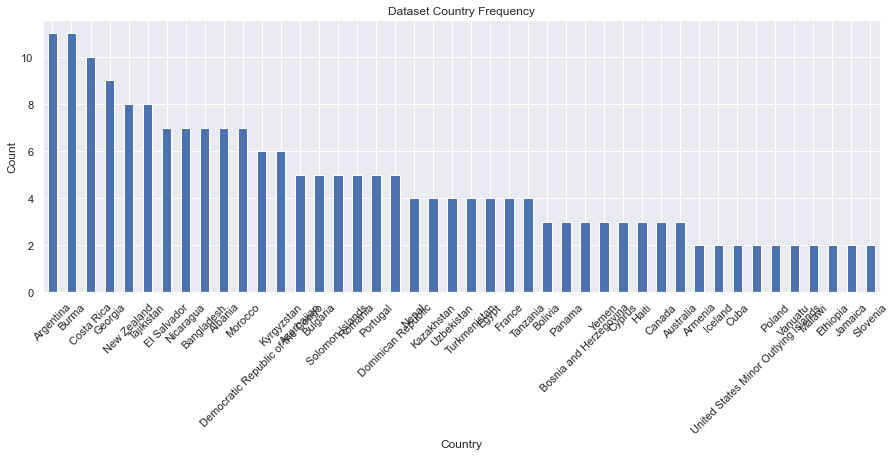

In [21]:
mid_freq_countries.plot(kind="bar", rot=45, figsize=(15,5))
plt.title("Dataset Country Frequency")
plt.xlabel("Country")
plt.ylabel("Count");

#### Which locations do not have lat/long/depth/magnitude data?

We notice that there are more countries than there is `(lat,long)` data. Let's see which countries do not have `(lat,long)`

In [22]:
world_earthquakes[(world_earthquakes["latitude"].isna()) | (world_earthquakes["longitude"].isna())]

,date,country,latitude,longitude,depth,magnitude,secondary_effects,deaths
439,1966-04-25 23:22:00,Uzbekistan,NaN,NaN,NaN,5.0,NaN,10
1318,2008-10-06 16:30:00,China,NaN,NaN,NaN,6.4,NaN,0
1319,2008-10-28 23:09:00,Pakistan,NaN,NaN,NaN,6.4,NaN,215
1322,2009-07-09 11:19:00,China,NaN,NaN,NaN,5.7,NaN,0
1323,2009-08-10 20:07:00,Japan,NaN,NaN,NaN,6.4,NaN,1
1324,2009-09-02 07:55:00,Indonesia,NaN,NaN,NaN,7.0,NaN,79
1325,2009-09-29 17:48:00,Samoa,NaN,NaN,8.1,8.1,NaN,189
1326,2009-09-30 10:16:00,Indonesia,NaN,NaN,NaN,7.6,NaN,1115
1329,2010-03-08 02:32:00,Turkey,NaN,NaN,NaN,6.1,NaN,42
1330,2010-03-11 14:39:00,Chile,NaN,NaN,NaN,6.9,landslide,1


### Looking into the map of the earthquakes

Let's look into those that have latitude and longitude

In [23]:
earthquakes_for_map = world_earthquakes[(~world_earthquakes["latitude"].isna()) & (~world_earthquakes["longitude"].isna())]
earthquakes_for_map

,date,country,latitude,longitude,depth,magnitude,secondary_effects,deaths
0,1900-05-11 17:23:00,Japan,38.700,141.100,5.0,7.000,NaN,0
1,1900-07-12 06:25:00,Turkey,40.300,43.100,NaN,5.900,NaN,140
2,1900-10-29 09:11:00,Venezuela,11.000,-66.000,0.0,7.700,NaN,0
3,1901-02-15 00:00:00,China,26.000,100.100,0.0,6.500,NaN,0
4,1901-03-31 07:11:00,Bulgaria,43.400,28.700,NaN,6.400,NaN,4
...,...,...,...,...,...,...,...,...
1328,2010-02-27 06:34:00,Chile,-35.846,-72.719,35.0,8.818,tsunami,521
1334,2011-03-11 14:46:00,Japan,38.322,142.369,24.4,9.000,tsunami,15894
1336,2011-04-07 14:32:00,Japan,38.200,140.000,66.0,7.100,NaN,0
1337,2011-09-18 12:40:00,India,27.723,88.064,19.7,6.900,landslide,111


Let's add a point datatype geometry column

In [24]:
earthquakes_for_map['geometry'] = earthquakes_for_map.apply(lambda x: Point((float(x.longitude), float(x.latitude))), axis=1)
earthquakes_for_map

<ipython-input-24-c0fdcb8d10b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  earthquakes_for_map['geometry'] = earthquakes_for_map.apply(lambda x: Point((float(x.longitude), float(x.latitude))), axis=1)


,date,country,latitude,longitude,depth,magnitude,secondary_effects,deaths,geometry
0,1900-05-11 17:23:00,Japan,38.700,141.100,5.0,7.000,NaN,0,POINT (141.1 38.7)
1,1900-07-12 06:25:00,Turkey,40.300,43.100,NaN,5.900,NaN,140,POINT (43.1 40.3)
2,1900-10-29 09:11:00,Venezuela,11.000,-66.000,0.0,7.700,NaN,0,POINT (-66 11)
3,1901-02-15 00:00:00,China,26.000,100.100,0.0,6.500,NaN,0,POINT (100.1 26)
4,1901-03-31 07:11:00,Bulgaria,43.400,28.700,NaN,6.400,NaN,4,POINT (28.7 43.4)
...,...,...,...,...,...,...,...,...,...
1328,2010-02-27 06:34:00,Chile,-35.846,-72.719,35.0,8.818,tsunami,521,POINT (-72.71899999999999 -35.846)
1334,2011-03-11 14:46:00,Japan,38.322,142.369,24.4,9.000,tsunami,15894,POINT (142.369 38.322)
1336,2011-04-07 14:32:00,Japan,38.200,140.000,66.0,7.100,NaN,0,POINT (140 38.2)
1337,2011-09-18 12:40:00,India,27.723,88.064,19.7,6.900,landslide,111,POINT (88.06399999999999 27.72300000000001)


Let's see if we can map these on the world map

In [25]:
worldmap = gpd.read_file('../data/world_countries.geojson')
print(worldmap.crs)
worldmap.head()

epsg:4326


,ADMIN,ISO_A3,geometry
0,Aruba,ABW,"POLYGON ((-69.99694 12.57758, -69.93639 12.531..."
1,Afghanistan,AFG,"POLYGON ((71.04980 38.40866, 71.05714 38.40903..."
2,Angola,AGO,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -..."
3,Anguilla,AIA,"MULTIPOLYGON (((-63.03767 18.21296, -63.09952 ..."
4,Albania,ALB,"POLYGON ((19.74777 42.57890, 19.74601 42.57993..."


In [26]:
# Clean the columns
worldmap = worldmap.drop(columns=['ISO_A3'])
worldmap = worldmap.rename(columns={"ADMIN":"country"})
worldmap.head()

,country,geometry
0,Aruba,"POLYGON ((-69.99694 12.57758, -69.93639 12.531..."
1,Afghanistan,"POLYGON ((71.04980 38.40866, 71.05714 38.40903..."
2,Angola,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -..."
3,Anguilla,"MULTIPOLYGON (((-63.03767 18.21296, -63.09952 ..."
4,Albania,"POLYGON ((19.74777 42.57890, 19.74601 42.57993..."


We need to build a geodataframe from earthquakes_for_map

In [27]:
earthquake_geodf = gpd.GeoDataFrame(earthquakes_for_map, 
                           crs = worldmap.crs, 
                           geometry = earthquakes_for_map['geometry'])
earthquake_geodf.head()

,date,country,latitude,longitude,depth,magnitude,secondary_effects,deaths,geometry
0,1900-05-11 17:23:00,Japan,38.7,141.1,5.0,7.0,NaN,0,POINT (141.10000 38.70000)
1,1900-07-12 06:25:00,Turkey,40.3,43.1,NaN,5.9,NaN,140,POINT (43.10000 40.30000)
2,1900-10-29 09:11:00,Venezuela,11.0,-66.0,0.0,7.7,NaN,0,POINT (-66.00000 11.00000)
3,1901-02-15 00:00:00,China,26.0,100.1,0.0,6.5,NaN,0,POINT (100.10000 26.00000)
4,1901-03-31 07:11:00,Bulgaria,43.4,28.7,NaN,6.4,NaN,4,POINT (28.70000 43.40000)


Now, we can join the 2 geodf together

In [28]:
# Joining
earthquake_by_country = gpd.sjoin(earthquake_geodf, worldmap, op = 'within')
earthquake_by_country.head()

,date,country_left,latitude,longitude,depth,magnitude,secondary_effects,deaths,geometry,index_right,country_right
0,1900-05-11 17:23:00,Japan,38.7,141.1,5.0,7.0,NaN,0,POINT (141.10000 38.70000),116,Japan
7,1902-01-30 14:01:00,Japan,40.5,141.3,35.0,6.9,NaN,1,POINT (141.30000 40.50000),116,Japan
26,1905-06-02 05:39:00,Japan,34.1,132.5,55.0,7.0,NaN,11,POINT (132.50000 34.10000),116,Japan
50,1909-08-14 06:31:00,Japan,35.4,136.3,5.0,6.7,NaN,41,POINT (136.30000 35.40000),116,Japan
52,1909-11-10 06:13:00,Japan,32.3,131.1,150.0,7.5,NaN,2,POINT (131.10000 32.30000),116,Japan


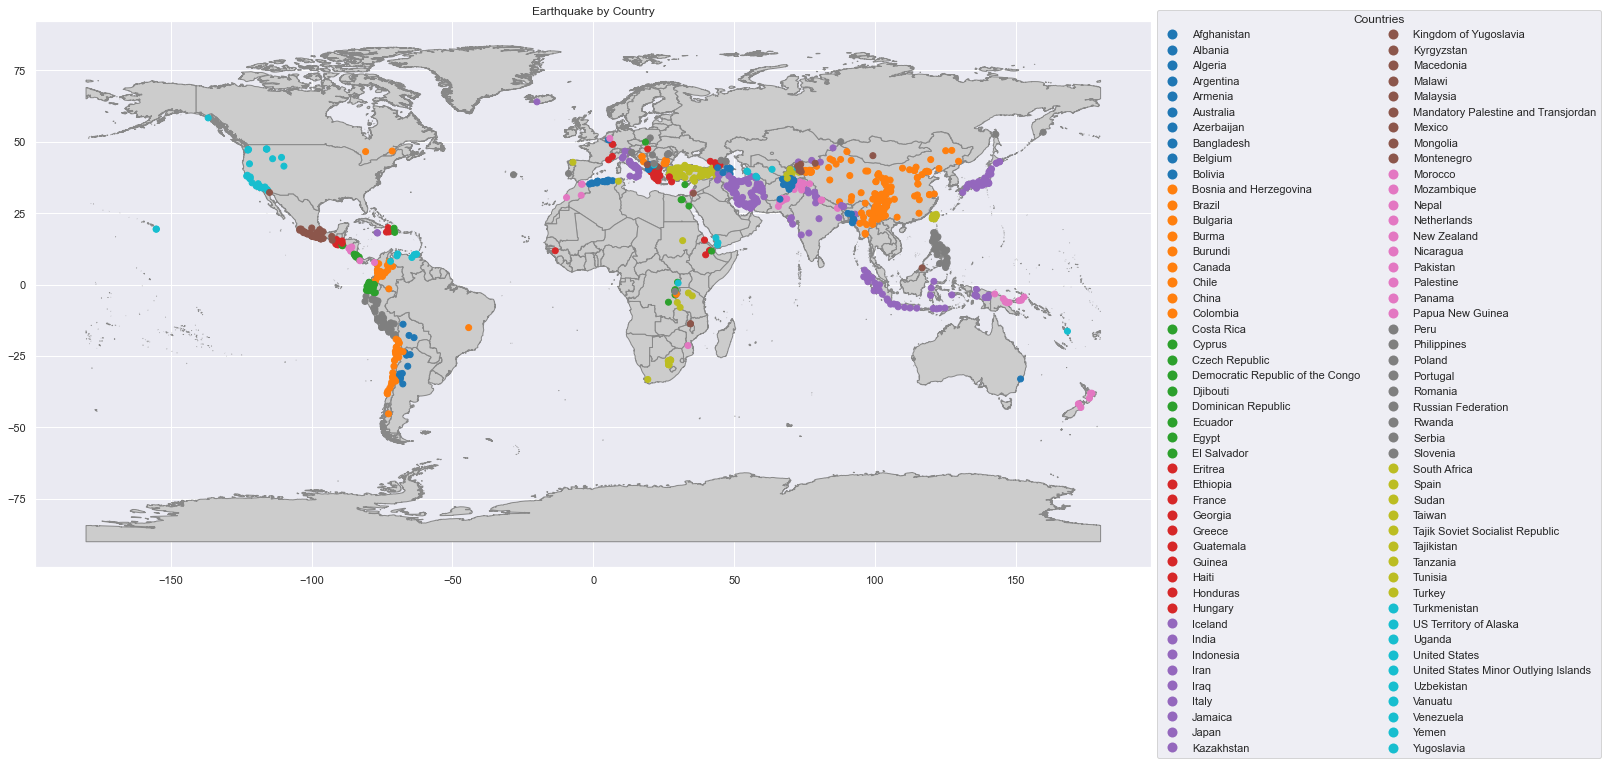

In [29]:
legend_kwds = {
    'title': 'Countries', 
    'loc': 'best', 
    'bbox_to_anchor': (1, 1.03), 
    'ncol': 2
}

ax = worldmap.plot(#column = 'country', 
              figsize=(20, 15),
              edgecolor = '#888',
              legend = False, 
              legend_kwds = legend_kwds,
              color='#ccc') # Qualitative color map from matplotlib

earthquake_by_country.plot(ax = ax, column = 'country_left', legend=True, legend_kwds = legend_kwds);
plt.title("Earthquake by Country")
plt.show();

In this one, we represent the size by the deaths

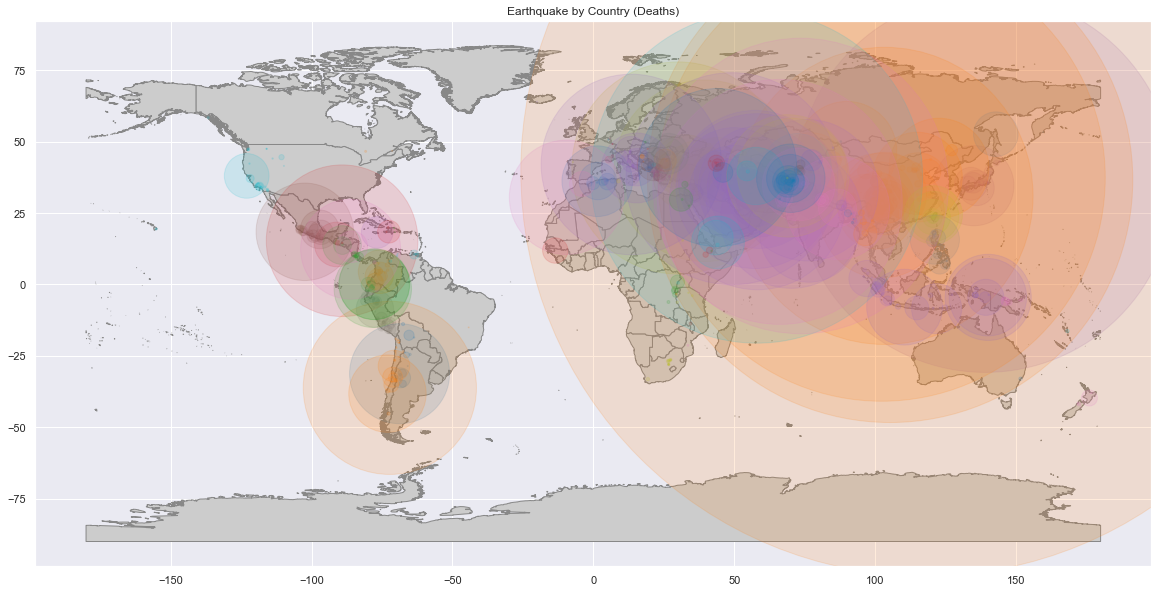

In [30]:
legend_kwds = {
    'title': 'Countries', 
    'loc': 'best', 
    'bbox_to_anchor': (1, 1.03), 
    'ncol': 2
}

ax = worldmap.plot(#column = 'country', 
              figsize=(20, 15),
              edgecolor = '#888',
              legend = False, 
              legend_kwds = legend_kwds,
              color='#ccc') # Qualitative color map from matplotlib

earthquake_by_country.plot(ax = ax, 
                           column = 'country_left', 
                           alpha=0.15, 
                           markersize=earthquake_by_country['deaths'])
#                           legend=True,
#                            legend_kwds = legend_kwds

plt.title("Earthquake by Country (Deaths)")
plt.show();

### Zooming into USA

In [31]:
earthquakes_in_usa = earthquake_by_country.loc[
    (earthquake_by_country['country_left'] == 'United States') | 
    (earthquake_by_country['country_left'] == 'United States Minor Outlying Islands')
]
earthquakes_in_usa.shape

(32, 11)

In [32]:
usa = worldmap.loc[
    (worldmap['country'] == 'United States Minor Outlying Islands') |
    (worldmap['country'] == 'United States of America') |
    (worldmap['country'] == 'United States Virgin Islands') |
    (worldmap['country'] == 'US Naval Base Guantanamo Bay')
]
usa

,country,geometry
236,United States Minor Outlying Islands,"MULTIPOLYGON (((-160.01244 -0.38209, -160.0247..."
238,United States of America,"MULTIPOLYGON (((-155.60652 20.13796, -155.5863..."
239,US Naval Base Guantanamo Bay,"MULTIPOLYGON (((-75.18396 19.93359, -75.19313 ..."
245,United States Virgin Islands,"MULTIPOLYGON (((-64.73078 17.76529, -64.70971 ..."


Now, let's just focus on the earthquakes in USA

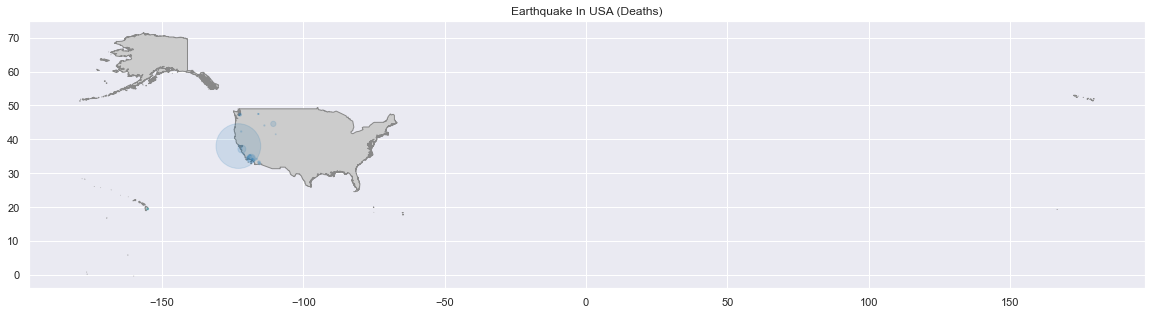

In [33]:
legend_kwds = {
    'title': 'Countries', 
    'loc': 'best', 
    'bbox_to_anchor': (1, 1.03), 
    'ncol': 2
}

ax = usa.plot(#column = 'country', 
              figsize=(20, 15),
              edgecolor = '#888',
              legend = False, 
              legend_kwds = legend_kwds,
              color='#ccc') # Qualitative color map from matplotlib

earthquakes_in_usa.plot(ax = ax,
                        column = 'country_left', 
                        alpha=0.15, 
                        markersize=earthquakes_in_usa['deaths'])
#                         legend=True,
#                         legend_kwds = legend_kwds

plt.title("Earthquake In USA (Deaths)")
plt.show();

Let's put this on a map to get a better visual

In [34]:
usa.geometry.centroid

<ipython-input-34-9dce43f0d90d>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  usa.geometry.centroid


236    POINT (-103.27713 13.30341)
238    POINT (-112.49573 45.68811)
239     POINT (-75.15467 19.92925)
245     POINT (-64.79765 17.98055)
dtype: geometry

In [35]:
# find the center of the larger polygon (238) and look at it
center = usa.geometry.centroid[238]
print(center)

POINT (-112.4957262864178 45.68811349999795)


<ipython-input-35-2089ab2827e2>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = usa.geometry.centroid[238]


Folium requires a location point as an array 
- with *latitude* first
- but shapely Points have *longitude* first 

In [36]:
# reverse the order when constructing the array for folium location
area_center = [center.y-5, center.x+15]

# check the order of area_center, the location for our folium map
print(area_center)

[40.688113499997954, -97.4957262864178]


Now creating a map of USA

In [37]:
# This fix is needed to display the map appropriately
earthquakes_in_usa = earthquakes_in_usa.drop("date", axis=1)
earthquakes_in_usa.head()

,country_left,latitude,longitude,depth,magnitude,secondary_effects,deaths,geometry,index_right,country_right
32,United States,38.000,-123.000,0.0,7.8,fire,2000,POINT (-123.00000 38.00000),238,United States of America
81,United States,32.800,-115.500,NaN,6.2,NaN,6,POINT (-115.50000 32.80000),238,United States of America
93,United States,33.812,-117.440,15.0,6.8,NaN,1,POINT (-117.44000 33.81200),238,United States of America
129,United States,34.500,-119.600,NaN,6.2,NaN,13,POINT (-119.60000 34.50000),238,United States of America
233,United States,33.222,-115.697,15.0,6.9,NaN,9,POINT (-115.69700 33.22200),238,United States of America


In [38]:
# Draw the map
map_usa = folium.Map(location = area_center, zoom_start = 4)

# Add the earthquakes
folium.GeoJson(earthquakes_in_usa).add_to(map_usa)

#iterate through earthquakes_in_usa to create locations and markers for each
#remember for Folium locations, lat needs to be listed first!!

for row_index, row_values in earthquakes_in_usa.iterrows():
    loc = [row_values['latitude'], row_values['longitude']]
    popup = "Deaths:" + str(row_values['deaths']) + "\n" + "Magnitude:" + str(row_values['magnitude']) + "\n" + "Depth:" + str(row_values['depth'])
    marker = folium.Marker(
        location = loc, 
        popup = popup) 
    
    marker.add_to(map_usa)

# Export map
# map_usa.save('../maps/map_usa.html')

# Display our map
map_usa

In [65]:
# Draw the map
map_usa_cluster = folium.Map(location = area_center, zoom_start = 4)

#create a marker cluster
marker_cluster = MarkerCluster().add_to(map_usa_cluster)

# Add the earthquakes
folium.GeoJson(earthquakes_in_usa).add_to(map_usa_cluster)

#create a list of locations and pass them to FastMarkerCluster()
locations = earthquakes_in_usa[['latitude', 'longitude']].values.tolist()
map_usa_cluster.add_child(
    FastMarkerCluster(locations)
)

#iterate through earthquakes_in_usa to create locations and markers for each
#remember for Folium locations, lat needs to be listed first!!

# inside the loop add each marker to the cluster
# for row_index, row_values in earthquakes_in_usa.iterrows():
#     loc = [row_values['latitude'], row_values['longitude']]
#     popup = "Deaths:" + str(row_values['deaths']) + "\n" + "Magnitude:" + str(row_values['magnitude']) + "\n" + "Depth:" + str(row_values['depth'])
#     mk = folium.Marker(
#         location = loc, 
#         popup = popup) 
    
#     mk.add_to(marker_cluster)

# Export map
# map_usa_cluster.save('../maps/map_usa_cluster.html')

# Display our map
map_usa_cluster

### Exploring `depth`, `magnitude`, and `deaths`

#### Which records do not have `depth` reported?

In [40]:
world_earthquakes[world_earthquakes["depth"].isna()]

,date,country,latitude,longitude,depth,magnitude,secondary_effects,deaths
1,1900-07-12 06:25:00,Turkey,40.30,43.10,NaN,5.9,NaN,140
4,1901-03-31 07:11:00,Bulgaria,43.40,28.70,NaN,6.4,NaN,4
9,1902-03-09 07:46:00,Turkey,40.70,33.60,NaN,5.5,NaN,4
15,1903-03-29 22:30:00,Palestine,32.20,35.30,NaN,5.7,NaN,20
16,1903-04-28 00:00:00,Turkey,39.14,42.65,NaN,7.0,NaN,3500
...,...,...,...,...,...,...,...,...
1330,2010-03-11 14:39:00,Chile,NaN,NaN,NaN,6.9,landslide,1
1331,2010-04-14 23:49:00,China,NaN,NaN,NaN,6.9,landslide,2698
1332,2011-02-21 23:51:00,New Zealand,NaN,NaN,NaN,6.3,liquification,185
1333,2011-03-10 04:58:00,China,NaN,NaN,NaN,5.4,NaN,0


#### Which records do not have `magnitude` reported?

In [41]:
world_earthquakes[world_earthquakes["magnitude"].isna()]

,date,country,latitude,longitude,depth,magnitude,secondary_effects,deaths
104,1921-08-14,Eritrea,15.61,39.445,NaN,NaN,NaN,0


#### Which records do not have `secondary_effects reported`?

In [42]:
world_earthquakes[world_earthquakes["secondary_effects"].isna()]

,date,country,latitude,longitude,depth,magnitude,secondary_effects,deaths
0,1900-05-11 17:23:00,Japan,38.7,141.1,5.0,7.0,NaN,0
1,1900-07-12 06:25:00,Turkey,40.3,43.1,NaN,5.9,NaN,140
2,1900-10-29 09:11:00,Venezuela,11.0,-66.0,0.0,7.7,NaN,0
3,1901-02-15 00:00:00,China,26.0,100.1,0.0,6.5,NaN,0
4,1901-03-31 07:11:00,Bulgaria,43.4,28.7,NaN,6.4,NaN,4
...,...,...,...,...,...,...,...,...
1333,2011-03-10 04:58:00,China,NaN,NaN,NaN,5.4,NaN,0
1335,2011-03-24 20:25:00,Burma,NaN,NaN,NaN,6.8,NaN,150
1336,2011-04-07 14:32:00,Japan,38.2,140.0,66.0,7.1,NaN,0
1338,2011-09-23 10:41:00,Turkey,38.6,43.5,7.2,7.1,NaN,601


#### Which records do not have `deaths` reported?

In [43]:
world_earthquakes[world_earthquakes["deaths"] == 0]

,date,country,latitude,longitude,depth,magnitude,secondary_effects,deaths
0,1900-05-11 17:23:00,Japan,38.7,141.1,5.0,7.0,NaN,0
2,1900-10-29 09:11:00,Venezuela,11.0,-66.0,0.0,7.7,NaN,0
3,1901-02-15 00:00:00,China,26.0,100.1,0.0,6.5,NaN,0
5,1901-08-09 09:23:00,Japan,40.5,142.5,35.0,7.2,tsunami,0
11,1902-07-03 15:36:00,China,43.2,129.6,20.0,6.7,NaN,0
...,...,...,...,...,...,...,...,...
1318,2008-10-06 16:30:00,China,NaN,NaN,NaN,6.4,NaN,0
1322,2009-07-09 11:19:00,China,NaN,NaN,NaN,5.7,NaN,0
1333,2011-03-10 04:58:00,China,NaN,NaN,NaN,5.4,NaN,0
1336,2011-04-07 14:32:00,Japan,38.2,140.0,66.0,7.1,NaN,0


#### Which records have `deaths` reported?

In [44]:
world_earthquakes[world_earthquakes["deaths"] > 0]

,date,country,latitude,longitude,depth,magnitude,secondary_effects,deaths
1,1900-07-12 06:25:00,Turkey,40.300,43.100,NaN,5.9,NaN,140
4,1901-03-31 07:11:00,Bulgaria,43.400,28.700,NaN,6.4,NaN,4
6,1901-11-15 20:15:00,New Zealand,-43.000,173.000,0.0,6.8,NaN,1
7,1902-01-30 14:01:00,Japan,40.500,141.300,35.0,6.9,NaN,1
8,1902-02-13 09:39:00,Azerbaijan,40.700,48.600,15.0,6.9,NaN,86
...,...,...,...,...,...,...,...,...
1332,2011-02-21 23:51:00,New Zealand,NaN,NaN,NaN,6.3,liquification,185
1334,2011-03-11 14:46:00,Japan,38.322,142.369,24.4,9.0,tsunami,15894
1335,2011-03-24 20:25:00,Burma,NaN,NaN,NaN,6.8,NaN,150
1337,2011-09-18 12:40:00,India,27.723,88.064,19.7,6.9,landslide,111


#### Summary Statistics for `depth`

We will only consider the ones that are not `na`. Depth is reported in Km.

In [45]:
# Only the ones that are not `na`
depth_data = world_earthquakes[~world_earthquakes["depth"].isna()]['depth']
depth_data.describe()

count    1250.000000
mean       29.531840
std        44.886951
min         0.000000
25%        10.000000
50%        18.000000
75%        35.000000
max       644.600000
Name: depth, dtype: float64

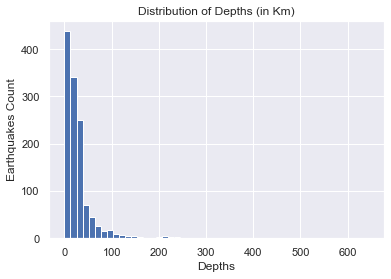

In [46]:
# sns.distplot(depth_data)
plt.hist(depth_data, bins=50)
plt.title("Distribution of Depths (in Km)")
plt.xlabel("Depths")
plt.ylabel("Earthquakes Count");

C:\Users\maeva\anaconda3\envs\geospatial\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


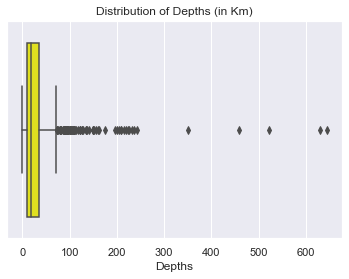

In [47]:
sns.boxplot(depth_data, color='yellow')
plt.title("Distribution of Depths (in Km)")
plt.xlabel("Depths");

C:\Users\maeva\anaconda3\envs\geospatial\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


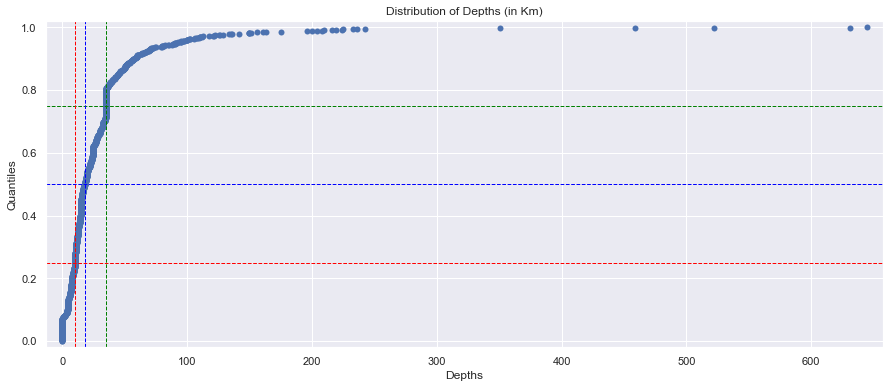

In [48]:
plot_ecdf(depth_data, 
          title='Distribution of Depths (in Km)', 
          xlabel='Depths')

#### Summary Statistics for `magnitude`

We will only consider the ones that are not `na`

In [49]:
# Only the ones that are not `na`
magnitude_data = world_earthquakes[~world_earthquakes["magnitude"].isna()]['magnitude']
magnitude_data.describe()

count    1339.000000
mean        6.398146
std         0.967859
min         2.000000
25%         5.700000
50%         6.400000
75%         7.100000
max         9.500000
Name: magnitude, dtype: float64

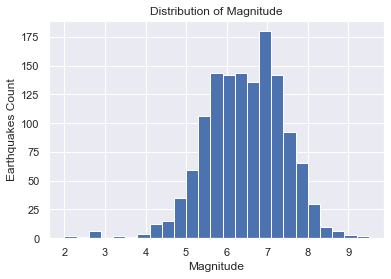

In [50]:
# sns.distplot(magnitude_data)
plt.hist(magnitude_data, bins=25)
plt.title("Distribution of Magnitude")
plt.xlabel("Magnitude")
plt.ylabel("Earthquakes Count");

C:\Users\maeva\anaconda3\envs\geospatial\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


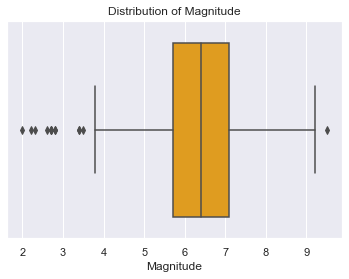

In [51]:
sns.boxplot(magnitude_data, color='orange')
plt.title("Distribution of Magnitude")
plt.xlabel("Magnitude");

C:\Users\maeva\anaconda3\envs\geospatial\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


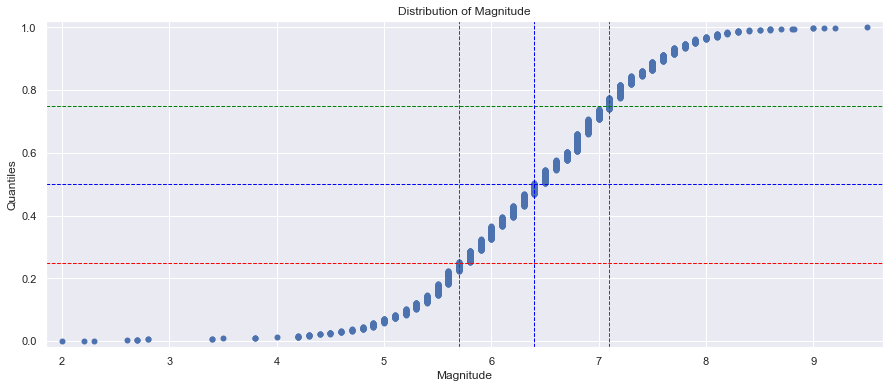

In [52]:
plot_ecdf(magnitude_data, 
          title="Distribution of Magnitude", 
          xlabel='Magnitude')

#### Summary Statistics for  `deaths`

We will only consider the ones that are not `na`.

In [53]:
# Only the ones that are not `na`
deaths_data = world_earthquakes[~world_earthquakes["deaths"].isna()]['deaths']
deaths_data.describe()

count      1340.000000
mean       2188.773134
std       22612.847499
min           0.000000
25%           2.000000
50%           8.000000
75%          76.500000
max      655237.000000
Name: deaths, dtype: float64

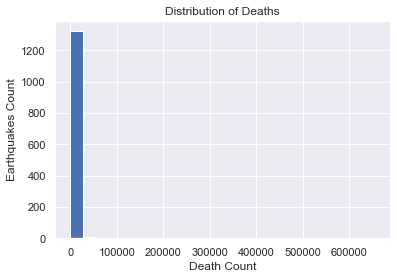

In [54]:
plt.hist(deaths_data, bins=25)
plt.title("Distribution of Deaths")
plt.xlabel("Death Count")
plt.ylabel("Earthquakes Count");

C:\Users\maeva\anaconda3\envs\geospatial\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


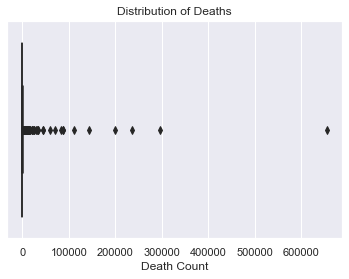

In [55]:
sns.boxplot(deaths_data, color='green')
plt.title("Distribution of Deaths")
plt.xlabel("Death Count");

C:\Users\maeva\anaconda3\envs\geospatial\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


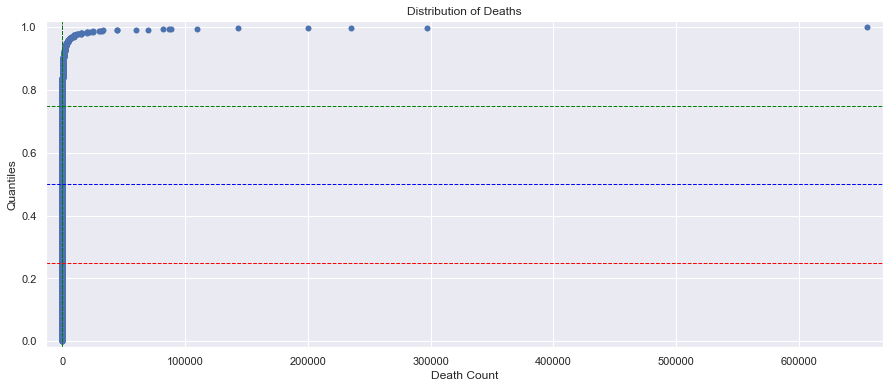

In [56]:
plot_ecdf(deaths_data, 
          title="Distribution of Deaths", 
          xlabel='Death Count')

It appears that most of the earthquakes did not cause deaths. What if we only focus on the ones which did?

In [57]:
deaths_data

0         0
1       140
2         0
3         0
4         4
       ... 
1335    150
1336      0
1337    111
1338    601
1339      0
Name: deaths, Length: 1340, dtype: int64

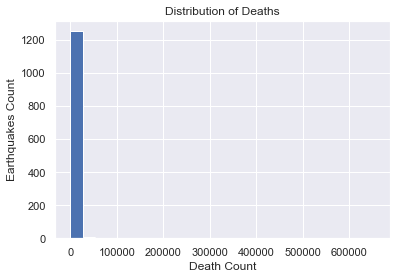

In [58]:
deaths_only_data = deaths_data[deaths_data > 0]
plt.hist(deaths_only_data, bins=25)
plt.title("Distribution of Deaths")
plt.xlabel("Death Count")
plt.ylabel("Earthquakes Count");

In [59]:
deaths_only_data

1         140
4           4
6           1
7           1
8          86
        ...  
1332      185
1334    15894
1335      150
1337      111
1338      601
Name: deaths, Length: 1270, dtype: int64

This data set is still highly skewed. Let's apply a log transformation to visualize better.

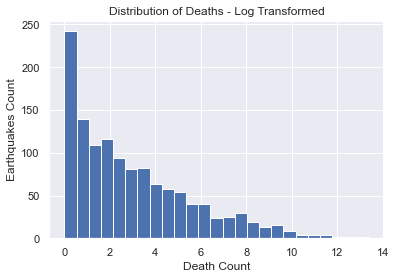

In [60]:
deaths_only_data_log = np.log(deaths_only_data)
plt.hist(deaths_only_data_log, bins=25)
plt.title("Distribution of Deaths - Log Transformed")
plt.xlabel("Death Count")
plt.ylabel("Earthquakes Count");

C:\Users\maeva\anaconda3\envs\geospatial\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


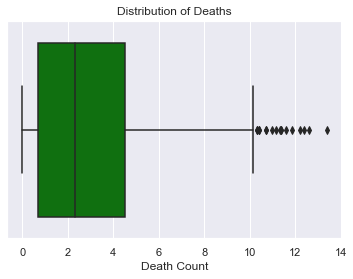

In [61]:
sns.boxplot(deaths_only_data_log, color='green')
plt.title("Distribution of Deaths")
plt.xlabel("Death Count");

C:\Users\maeva\anaconda3\envs\geospatial\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


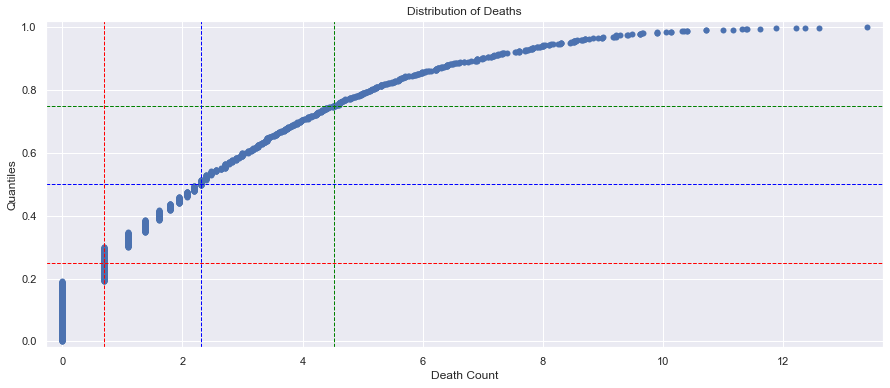

In [62]:
plot_ecdf(deaths_only_data_log, 
          title="Distribution of Deaths", 
          xlabel='Death Count')

### Is there any correlation with deaths?

In [63]:
# List of options
x_axis_options = ['depth', 'magnitude', 'secondary_effects']
y_axis_options = ['depth', 'magnitude', 'secondary_effects', 'deaths']
hue_options = ['depth', 'magnitude', 'secondary_effects', 'deaths']
size_options = ['depth', 'magnitude', 'deaths']

@interact(
    # Specifying the handler for the n argument in the function
    x = widgets.Dropdown(
        options=x_axis_options, # The list of available options
        index=None,             # The index of the default selection
        value='depth',               # The value of the default selection
        label='depth',               # The label corresponding to the selected value
        disabled=False,         # Whether to disable user changes
        description='x-axis'    # Label
    ),
    y = widgets.Dropdown(
        options=y_axis_options, # The list of available options
        index=3,                # The index of the default selection
        value='deaths',         # The value of the default selection
        label='deaths',         # The label corresponding to the selected value
        disabled=False,         # Whether to disable user changes
        description='y-axis'    # Label
    )
#     hue = widgets.Dropdown(
#         options=hue_options,  # The list of available options
#         index=2,                # The index of the default selection
#         value='secondary_effects', # The value of the default selection
#         label='secondary_effects', # The label corresponding to the selected value
#         disabled=False,         # Whether to disable user changes
#         description='Hue'       # Label
#     ),
#     size = widgets.Dropdown(
#         options=size_options,   # The list of available options
#         index=1,                # The index of the default selection
#         value='magnitude',      # The value of the default selection
#         label='magnitude',      # The label corresponding to the selected value
#         disabled=False,         # Whether to disable user changes
#         description='Size'      # Label
#     ),
)
def plot_scatterplot_corr(x, y):
    """Plot a scatterplot to show correlations"""

    plt.figure(figsize=(10,6))
    
    sns.scatterplot(
        data=world_earthquakes, 
        x=x, 
        y=y,
        linewidth=0
#         hue=hue, 
#         size=size
    )

    plt.xticks(rotation=45)
    
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     # Labels
#     plt.xlabel('Year')
#     plt.ylabel('Population (in billion)')
    plt.title('Variables Correlation to Deaths')

#     # Axis ticks
#     plt.yticks([0, 2, 4, 6, 8, 10, 12], 
#                ['0', '2 B', '4 B','6 B', '8 B', '10 B', '12 B'])

    # Finally, show the plot
    plt.show()

interactive(children=(Dropdown(description='x-axis', options=('depth', 'magnitude', 'secondary_effects'), valu…

**Conclusion:**
- Shallower earthquakes tend to cause more deaths
  - Shallower earthquakes have higher magnitude 
- Higher magnitude earthquakes tend to cause more deaths
- For secondary effects, the most deadly are:
  - Tsunami with landslide
  - Tsunami with fire
  - Tsunami
  - Landslide
  - Landslide with liquification
- The most occuring secondary effects with magnitude levels are:
  - Tsunami
  - Landslide
  - Tsunami with landslide
- Most secondary effects occurs for shallower earthquakes

**It appears that the recipe for deadly earthquakes is:**
- **Shallow (less than 100km)**
- **Secondary effects of Tsunami and/or landslide**
- **Higher Magnitude (above 6)**